In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import networkx as nx
import warnings
import collections
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
import re
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import EnglishStemmer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix
import itertools
%matplotlib inline
warnings.filterwarnings('ignore')

# Part 1

#### NOTE: For better visualization, we will always draw the samples treated by blue and the ones not treated by orange

In [2]:
df = pd.read_csv("lalonde.csv")
df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


# 1. A naive analysis

In [3]:
df[df['treat'] == 1].describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [4]:
df[df['treat'] == 0].describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


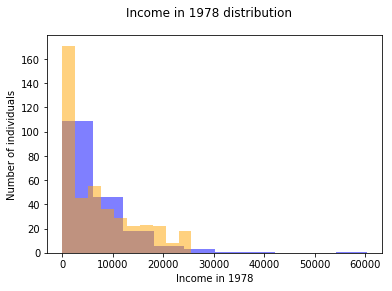

The mean income for the people who took the workshope is 6349.14 and standard deviation is 7867.4
The mean income for the people who didn't take the workshope is 6984.17 and standard deviation is 7294.16


In [5]:
#Plot the two graphs on the same --> better for scale
plt.hist(df[df['treat'] == 1]['re78'],color="blue",alpha=0.5)
plt.hist(df[df['treat'] == 0]['re78'],color="orange",alpha=0.5)
plt.ylabel("Number of individuals")
plt.xlabel("Income in 1978")
plt.suptitle("Income in 1978 distribution")
plt.show()
print ("The mean income for the people who took the workshope is {} and standard deviation is {}".format(round(df[df['treat'] == 1]['re78'].mean(),2), round(df[df['treat'] == 1]['re78'].std(),2)))
print ("The mean income for the people who didn't take the workshope is {} and standard deviation is {}".format(round(df[df['treat'] == 0]['re78'].mean(),2), round(df[df['treat'] == 0]['re78'].std(),2)))


#### Conclusion : A naive data scientist would conclude that a job training program resulted in a decrease of the earnings

# 2. A closer look at the data

In [6]:
#Initialize new dataframes for treated and untreated
untreated_df = df[df['treat'] == 0]
treated_df = df[df['treat'] == 1]

In [7]:
#Display both descriptions in one table -- for better visualization
index_array = treated_df.describe().index
sum_df = pd.DataFrame(index = index_array)
attributes = ['age','age','educ','educ','black','black','hispan','hispan','married', 'married'
              ,'nodegree','nodegree','re74','re74','re75','re75']
columns = [('age','Treated Group'),('age','Untreated Group'),('educ','Treated Group'),('educ','Untreated Group')
           ,('black','Treated Group'),('black','Untreated Group'),('hispan','Treated Group'),('hispan','Untreated Group')
           ,('married','Treated Group'),('married','Untreated Group'),('nodegree','Treated Group'),('nodegree','Untreated Group')
          ,('re74','Treated Group'),('re74','Untreated Group'),('re75','Treated Group'),('re75','Untreated Group')]

combination_df  = pd.DataFrame(index = index_array, columns = columns)
combination_df.columns=pd.MultiIndex.from_tuples(columns)
i = 0
for col, att in zip(columns, attributes):
    if i%2==0:
        combination_df[col] = np.array(treated_df[att].describe())
    else: 
        combination_df[col] = np.array(untreated_df[att].describe())
    i+=1
        
combination_df

age                          educ                  \
      Treated Group Untreated Group Treated Group Untreated Group   
count    185.000000      429.000000    185.000000      429.000000   
mean      25.816216       28.030303     10.345946       10.235431   
std        7.155019       10.786653      2.010650        2.855238   
min       17.000000       16.000000      4.000000        0.000000   
25%       20.000000       19.000000      9.000000        9.000000   
50%       25.000000       25.000000     11.000000       11.000000   
75%       29.000000       35.000000     12.000000       12.000000   
max       48.000000       55.000000     16.000000       18.000000   

              black                        hispan                  \
      Treated Group Untreated Group Treated Group Untreated Group   
count    185.000000      429.000000    185.000000      429.000000   
mean       0.843243        0.202797      0.059459        0.142191   
std        0.364558        0.402552      0.237124        0.349654   
min        0.000000        0.000000      0.000000        0.000000   
25%        1.000000        0.000000      0.000000        0.000000   
50%        1.000000        0.000000      0.000000        0.000000   
75%        1.000000        0.000000      0.000000        0.000000   
max        1.000000        1.000000      1.000000        1.000000   

            married                      nodegree                  \
      Treated Group Untreated Group Treated Group Untreated Group   
count    185.000000      429.000000    185.000000      429.000000   
mean       0.189189        0.512821      0.708108        0.596737   
std        0.392722        0.500419      0.455867        0.491126   
min        0.000000        0.000000      0.000000        0.000000   
25%        0.000000        0.000000      0.000000        0.000000   
50%        0.000000        1.000000      1.000000        1.000000   
75%        0.000000        1.000000      1.000000        1.000000   
max        1.000000        1.000000      1.000000        1.000000   

               re74                          re75                  
      Treated Group Untreated Group Treated Group Untreated Group  
count    185.000000      429.000000    185.000000      429.000000  
mean    2095.573689     5619.236506   1532.055314     2466.484443  
std     4886.620353     6788.750796   3219.250870     3291.996183  
min        0.000000        0.000000      0.000000        0.000000  
25%        0.000000        0.000000      0.000000        0.000000  
50%        0.000000     2547.047000      0.000000     1086.726000  
75%     1291.468000     9277.128000   1817.284000     3881.419000  
max    35040.070000    25862.320000  25142.240000    18347.230000

We found that on average, the people who did not do the training were already earning higher than the people who did the training. The reason that might explain this phenomena is that ***people who did the training were motivated to do the training because they had lower income, while people with already higher income (on average) didn't have the same motivation***

Another thing we would like to note is that the number of people who did the training was ***185*** where the number of people who didn't do the training were ***429***.

For the "treated" individuals, we note that the median (50%) is smaller than the mean, indicating that the data is ***positvely skewed***. Same goes for the individuals that were not treated.

### Feature : age

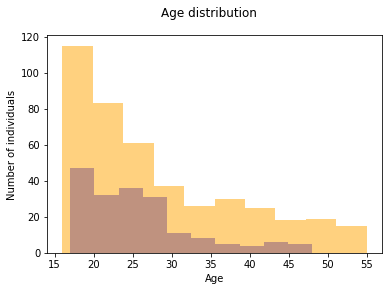

In [8]:
#Description of treated group w.r.t feature age
plt.hist(treated_df['age'],color="blue",alpha=0.5)
plt.hist(untreated_df['age'],color="orange",alpha=0.5)
plt.ylabel("Number of individuals")
plt.xlabel("Age")
plt.suptitle("Age distribution")
plt.show()

The distribution visually looks the same. The difference between the numbers is due to the unbalanced number of samples as mentioned before : ***Treated is 180 while Untreated is 429*** <br/>
In addition, from the previous table, ***the range of the untreated samples is larger where the min and max are 16 and 55 respectively while in the treated samples it corresponds to 17 and 48. The means and standard deviation of the two samples are similar, however the treated sample has a smaller standard deviation which means it's more centered around the mean while the untreated has a larger distribution, this may be because we have a wider range of values for the second untreated sample. The mean of the untreated sample is 28 while that of the treated sample is 25, the age difference is significant since 3 additional years of experience should lead to a higher income.***

***In addition, we would like to note that the two distributions are found to be positively skewed.***

### Feature : educ

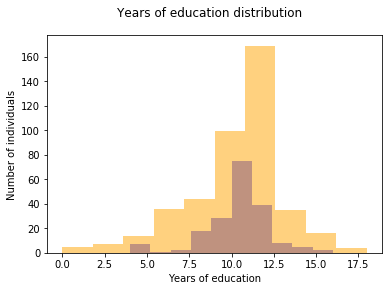

In [9]:
#Description of treated group w.r.t feature age
plt.hist(treated_df['educ'],color="blue",alpha=0.5)
plt.hist(untreated_df['educ'],color="orange",alpha=0.5)
plt.ylabel("Number of individuals")
plt.xlabel("Years of education")
plt.suptitle("Years of education distribution")
plt.show()

Similar to the previously mentioned commment, distribution is similar but there's an unbalance in the number of samples. In addition, we note that ***the mean and standard deviation for both treated and untreated samples are similar and that the range of for the untreated sample is bigger. The two distributions look close to a normal distribution***

### Feature : black

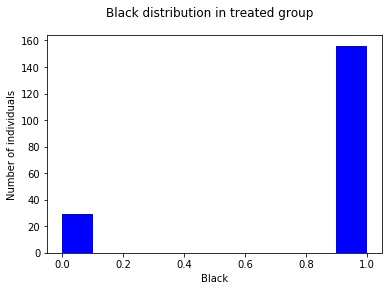

In [10]:
#Description of treated group w.r.t feature black
plt.hist(treated_df['black'],color="blue")
plt.ylabel("Number of individuals")
plt.xlabel("Black")
plt.suptitle("Black distribution in treated group")
plt.show()

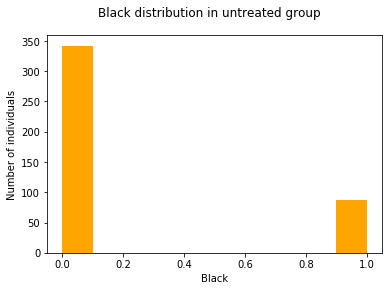

In [11]:
#Description of untreated group w.r.t feature black
plt.hist(untreated_df['black'],color="orange")
plt.ylabel("Number of individuals")
plt.xlabel("Black")
plt.suptitle("Black distribution in untreated group")
plt.show()

Since the number of samples is not the same for the two population, we will take into account the ration of black to non black

In [12]:
print ("The ratio of black to non-black in the treated is {}".format(round(len(treated_df[treated_df['black']==1])/len(treated_df[treated_df['black']==0]),2)))
print ("The ratio of black to non-black in the untreated is {}".format(round(len(untreated_df[untreated_df['black']==1])/len(untreated_df[untreated_df['black']==0]),2)))


The ratio of black to non-black in the treated is 5.38
The ratio of black to non-black in the untreated is 0.25


There's a clear discrepancy between the "treated" and "untreated" groups w.r.t. the feature black. ***Both distributions are "skewed" but the skeweness is opposite for the treated and untreated.***

### Feature : hispanic

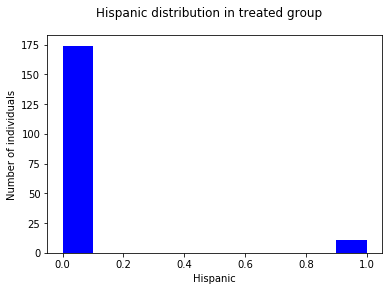

In [13]:
#Description of treated group w.r.t feature hispan
plt.hist(treated_df['hispan'],color="blue")
plt.ylabel("Number of individuals")
plt.xlabel("Hispanic")
plt.suptitle("Hispanic distribution in treated group")
plt.show()

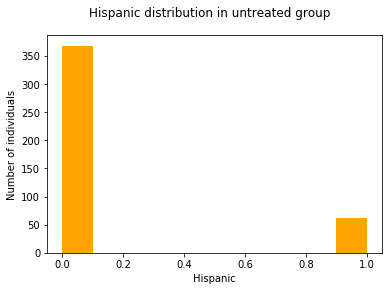

In [14]:
#Description of untreated group w.r.t feature hispan
plt.hist(untreated_df['hispan'],color="orange")
plt.ylabel("Number of individuals")
plt.xlabel("Hispanic")
plt.suptitle("Hispanic distribution in untreated group")
plt.show()

In [15]:
print ("The ratio of hispanic to non-hispanic in the treated is {}".format(round(len(treated_df[treated_df['hispan']==1])/len(treated_df[treated_df['hispan']==0]),2)))
print ("The ratio of hispanic to non-hispanic in the untreated is {}".format(round(len(untreated_df[untreated_df['hispan']==1])/len(untreated_df[untreated_df['hispan']==0]),2)))


The ratio of hispanic to non-hispanic in the treated is 0.06
The ratio of hispanic to non-hispanic in the untreated is 0.17


In this case and similar, it is more indicative to consider the ratio of hispanic to non-hispanic in the treated to the untreated samples. The ratio of hispanic to non-hispanic in the treated is 3 times less than the one in the untreated. ***Both treated and untreated have the same "positively skewed" distribution with the ratio of hispanic to non-hispanic very low***, indicating the presence of a small number of hispanic in both samples.

### Feature : married

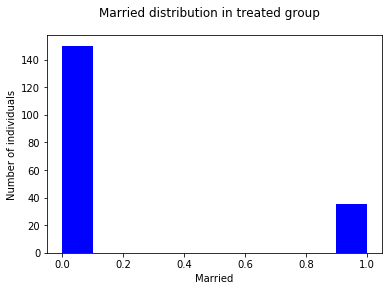

In [16]:
#Description of treated group w.r.t feature married
plt.hist(treated_df['married'],color="blue")
plt.ylabel("Number of individuals")
plt.xlabel("Married")
plt.suptitle("Married distribution in treated group")
plt.show()

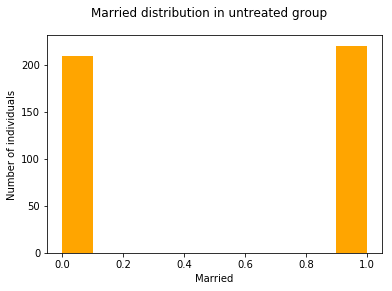

In [17]:
#Description of untreated group w.r.t feature married
plt.hist(untreated_df['married'],color="orange")
plt.ylabel("Number of individuals")
plt.xlabel("Married")
plt.suptitle("Married distribution in untreated group")
plt.show()

The ratio of unmarried (at the time of the training) in the treated group is bigger than the ratio in the untreated group (which is clear by the histogram alone). We noted before that the treated group had on average lower income and that this may be the motivation to take the training program at the first place. ***We might think that the treated group having at the time of the training program lower income would tend to be unmarried***

### Feature : no degree

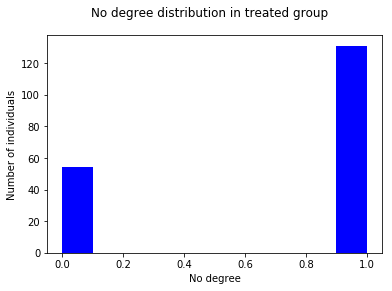

In [18]:
#Description of treated group w.r.t feature nodegree
plt.hist(treated_df['nodegree'],color="blue")
plt.ylabel("Number of individuals")
plt.xlabel("No degree")
plt.suptitle("No degree distribution in treated group")
plt.show()

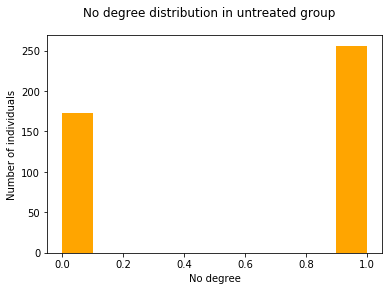

In [19]:
#Description of untreated group w.r.t feature nodegree
plt.hist(untreated_df['nodegree'],color="orange")
plt.ylabel("Number of individuals")
plt.xlabel("No degree")
plt.suptitle("No degree distribution in untreated group")
plt.show()

In [20]:
print ("The ratio of nodegree to degree in the treated is {}".format(round(len(treated_df[treated_df['nodegree']==1])/len(treated_df[treated_df['nodegree']==0]),2)))
print ("The ratio of nodegree to degree in the untreated is {}".format(round(len(untreated_df[untreated_df['nodegree']==1])/len(untreated_df[untreated_df['nodegree']==0]),2)))


The ratio of nodegree to degree in the treated is 2.43
The ratio of nodegree to degree in the untreated is 1.48


The ratio is a more indicative statistic to consider, we find that the people in the treated group are less educated than the ones in the untreated group

### Feature : re74

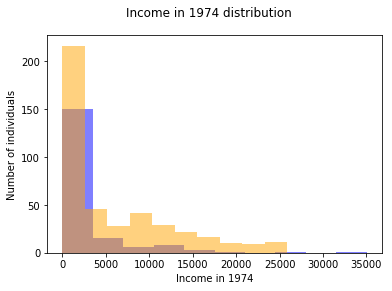

In [21]:
#Comparing treated and untreated group w.r.t feature re74
plt.hist(treated_df['re74'],color="blue",alpha=0.5)
plt.hist(untreated_df['re74'],color="orange",alpha=0.5)
plt.ylabel("Number of individuals")
plt.xlabel("Income in 1974")
plt.suptitle("Income in 1974 distribution")
plt.show()

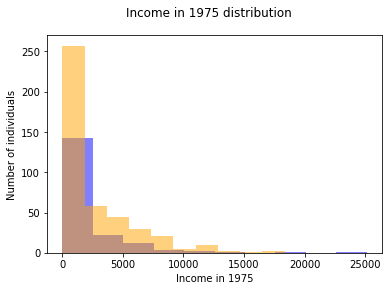

In [22]:
#Comparing treated and untreated group w.r.t feature re75
plt.hist(treated_df['re75'],color="blue",alpha=0.5)
plt.hist(untreated_df['re75'],color="orange",alpha=0.5)
plt.ylabel("Number of individuals")
plt.xlabel("Income in 1975")
plt.suptitle("Income in 1975 distribution")
plt.show()

We decided to plot the two graphs on the same one to be able to see them on the same scale. We notice that there a bit more than 50% (median) of the treated group had an income of 0 while the median of the untreated group was bigger than zero. ***We note that the average re74 and re75 for the untreated group is bigger than the treated group, which might be due to the fact that people with lower income would tend to do the job training more than the ones with already "high" income***

### All features conclusion:

The naive data scientist would have assumed that given the training program doesn't benefit the individuals by much, since people who didn't take the training had a higher salary. <br/>
Opposite to this conclusion, we noted that the population studied as "treated" and "untreated" differ to a point that we cannot compare the two dataset. Some of the things that enforces this idea is that race/gender may influence the salary of a person (due to discrimination) and having very different distribution between the treated and untreated it is difficult to compare them without any pre-processing. In addition, we noted that people who were labeled as treated had a lower income with comparison to the people who didn't take it during the re74 and re75, this may be because people with lower income wanted to take the training to increase their salary (opposed to people who had relatively higher salary). We also note that some salaries include very large outliers that is influencing the mean in both samples that should be taken into account. Finally, we like to note that the number of people who were untreated is 2.3 times higher than the treated ones.

# 3. A propensity score model

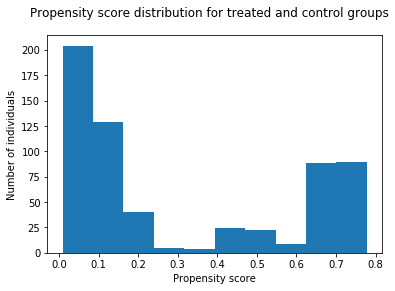

In [23]:
logistic = linear_model.LogisticRegression()
#Get target and features
df_target = df.iloc[:,1]
df_features = df.iloc[:,2:10]

#Fit model
logistic.fit(df_features,df_target)
y_prob = logistic.predict_proba(df_features)

#Get predicted labels
y_pred = logistic.predict(df_features)

#y_prob is the probability of someone belonging to group untreated and treated
#y_prob[:,1] is the probability of belonging to the group treated
plt.hist(y_prob[:,1])
plt.ylabel("Number of individuals")
plt.xlabel("Propensity score")
plt.suptitle("Propensity score distribution for treated and control groups")
plt.show()

# 4. Balancing the dataset via matching

When creating the graph, we will only connect the nodes that are from different classes (treated and untreated). ***There will be no connection between the same class***. In addition, ***we will put the weight for each edge to be equal to the inverse of the absolute difference between their propensity score. The reason being that networkx has a max_weight_matching so to get the minimum difference we would need to inverse it***

In [32]:
#Create an empty graph to fill
G = nx.empty_graph()

#Use a color map for visualization. 
#We follow the same schema as before but now we color based on the probability of belonging to treated or untreated group.
color_map = []
#Create the nodes without connecting them
for i in range(0,len(y_prob[:,1])):
    G.add_node(i)
    if(df_target[i] == 0):
        color_map.append('orange')
    else:
        color_map.append('blue')

# Connect the nodes with edges of values the inverse of the absolute difference between the probabilities
# Later we will use the get max, since we want to get the minimum distance we will inverse them here
for i in range(0,len(y_prob[:,1])-1):
    for j in range(i+1,len(y_prob[:,1])):
        if(((df_target[i] == 0 and df_target[j] == 1) or (df_target[i] == 1 and df_target[j] == 0)) and (not G.has_edge(i,j))):
            if (abs(y_prob[i,1]-y_prob[j,1]) <= 0.000000000001): #To avoid overflow
                G.add_edge(i,j,weight=1000000000000) # Set it as an upper limit
            else:
                G.add_edge(i,j,weight=(1/abs(y_prob[i,1]-y_prob[j,1])))


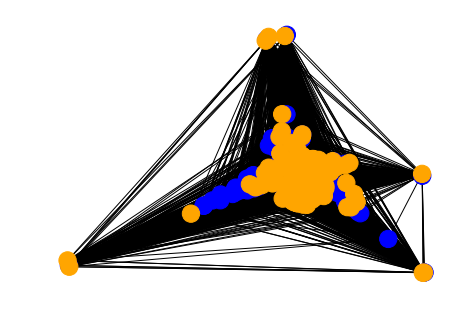

In [33]:
#Visualize the graph
nx.draw(G,node_color = color_map)

***The max_weight_matching function matches a subset of edges in which no node occurs more than once. The cardinality of a matching is the number of matched edges. It picks for each node the one that is furthest away from all of its connections (which in our case means the most similar to it).***

In [34]:
#Get the maximal matching based on the weights of the edges
#which will give us the indices of the pairs from the untreated to map 
#to the indices in the treated
matching = nx.max_weight_matching(G)

In [35]:
count_treated = 0
count_untreated = 0
for i in range(0,len(y_prob[:,1])):
    if df_target[i] == 1:
        count_treated += 1
    else:
        count_untreated += 1

#Compare the number of pairs w.r.t. the bottleneck of the two classes (in our case the treated group)
#We divided by two to avoid redundant edges
print ("The number of pairs found in the max_weight_matching/2 of the graph is {},\nwhich is equal to the min of the number of samples predicted to be treated and untreated which is : {}".format(len(matching)/2,min(count_untreated,count_treated)))


The number of pairs found in the max_weight_matching/2 of the graph is 185.0,
which is equal to the min of the number of samples predicted to be treated and untreated which is : 185


The number of edges, which is 185, does correspond to the number of samples in the bottleneck group which is the treated group


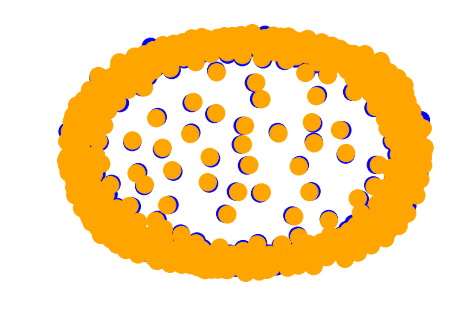

In [36]:
#Draw new graph with edges from the max_weight_matching
G_max = nx.empty_graph()

for i in range(0,len(y_prob[:,1])):
    G_max.add_node(i)
    if(df_target[i] == 0):
        color_map.append('orange')
    else:
        color_map.append('blue')


for node in matching:
    if(not G_max.has_edge(node,matching[node])):
        G_max.add_edge(node,matching[node])
        
nx.draw(G_max,node_color = color_map)
print ("The number of edges, which is {}, does correspond to the number of samples in the bottleneck group which is the treated group".format(G_max.number_of_edges()))

In [39]:
#Create treated and untreated df based on the matched pairs
index_treated = []
index_untreated = []

for index in matching:
    if(df_target[index] == 0):
        index_untreated.append(index)
    else:
        index_treated.append(index)
        
        
#Check that they are the same
#They contain the indices of the elements from the initial dataframe
print (len(index_untreated))
print (len(index_treated))

185
185


In [40]:
#Dataframe of treated based on the matched pairs
df_treated_matched = df.iloc[index_treated,:]
df_treated_matched.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
24,NSW25,1,18,10,1,0,0,1,0.0,0.0,11163.170
28,NSW29,1,17,10,1,0,0,1,0.0,0.0,16218.040
42,NSW43,1,17,8,1,0,0,1,0.0,0.0,8061.485
30,NSW31,1,17,10,1,0,0,1,0.0,0.0,0.000
52,NSW53,1,18,11,1,0,0,1,0.0,0.0,0.000


In [41]:
#Dataframe of untreated based on the matched pairs
df_untreated_matched = df.iloc[index_untreated,:]
df_untreated_matched.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
595,PSID411,0,18,10,1,0,0,1,0.0,0.0,5306.516
585,PSID401,0,17,10,1,0,0,1,0.0,0.0,1053.619
582,PSID398,0,17,8,1,0,0,1,0.0,0.0,4520.366
576,PSID392,0,17,10,1,0,0,1,0.0,0.0,0.000
573,PSID389,0,18,11,1,0,0,1,0.0,0.0,7146.286


### Comparing the outcomes of the two groups

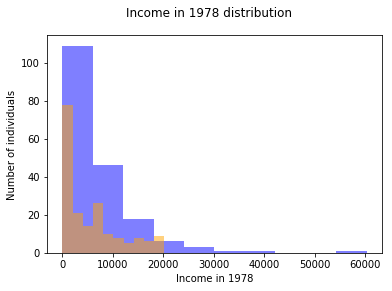

In [42]:
plt.hist(df_treated_matched['re78'],color="blue",alpha=0.5)
plt.hist(df_untreated_matched['re78'],color="orange",alpha=0.5)
plt.ylabel("Number of individuals")
plt.xlabel("Income in 1978")
plt.suptitle("Income in 1978 distribution")
plt.show()

In [46]:
print ("The mean for the treated group is {}".format(df_treated_matched['re78'].mean()))
print ("The mean for the untreated group is {}".format(df_untreated_matched['re78'].mean()))

The mean for the treated group is 6349.143530270271
The mean for the untreated group is 5312.474907297297


We would like to note the fact that ***now both treated and untreated groups have the same number of samples***. We can clearly see from the mean of both groups, that the outcome of the treated group is higher than the untreated group, implying that the program did actually improve. ***However, we will see in the next part that some features are not that similar and may cause our control group not to be comparable with our treat group***

In [47]:
#Display both descriptions in one table -- for better visualization
#This one is for the matched groups after processing

index_array = df_treated_matched.describe().index
sum_df = pd.DataFrame(index = index_array)
attributes = ['age','age','educ','educ','black','black','hispan','hispan','married', 'married'
              ,'nodegree','nodegree','re74','re74','re75','re75']
columns = [('age','Treated Group'),('age','Untreated Group'),('educ','Treated Group'),('educ','Untreated Group')
           ,('black','Treated Group'),('black','Untreated Group'),('hispan','Treated Group'),('hispan','Untreated Group')
           ,('married','Treated Group'),('married','Untreated Group'),('nodegree','Treated Group'),('nodegree','Untreated Group')
          ,('re74','Treated Group'),('re74','Untreated Group'),('re75','Treated Group'),('re75','Untreated Group')]

combination_df  = pd.DataFrame(index = index_array, columns = columns)
combination_df.columns=pd.MultiIndex.from_tuples(columns)
i = 0
for col, att in zip(columns, attributes):
    if i%2==0:
        combination_df[col] = np.array(df_treated_matched[att].describe())
    else: 
        combination_df[col] = np.array(df_untreated_matched[att].describe())
    i+=1
        
combination_df

age                          educ                  \
      Treated Group Untreated Group Treated Group Untreated Group   
count    185.000000      185.000000    185.000000      185.000000   
mean      25.816216       23.713514     10.345946       10.162162   
std        7.155019        9.644726      2.010650        2.861984   
min       17.000000       16.000000      4.000000        0.000000   
25%       20.000000       17.000000      9.000000        9.000000   
50%       25.000000       19.000000     11.000000       10.000000   
75%       29.000000       26.000000     12.000000       12.000000   
max       48.000000       55.000000     16.000000       18.000000   

              black                        hispan                  \
      Treated Group Untreated Group Treated Group Untreated Group   
count    185.000000       185.00000    185.000000      185.000000   
mean       0.843243         0.47027      0.059459        0.118919   
std        0.364558         0.50047      0.237124        0.324571   
min        0.000000         0.00000      0.000000        0.000000   
25%        1.000000         0.00000      0.000000        0.000000   
50%        1.000000         0.00000      0.000000        0.000000   
75%        1.000000         1.00000      0.000000        0.000000   
max        1.000000         1.00000      1.000000        1.000000   

            married                      nodegree                  \
      Treated Group Untreated Group Treated Group Untreated Group   
count    185.000000      185.000000    185.000000      185.000000   
mean       0.189189        0.167568      0.708108        0.627027   
std        0.392722        0.374495      0.455867        0.484907   
min        0.000000        0.000000      0.000000        0.000000   
25%        0.000000        0.000000      0.000000        0.000000   
50%        0.000000        0.000000      1.000000        1.000000   
75%        0.000000        0.000000      1.000000        1.000000   
max        1.000000        1.000000      1.000000        1.000000   

               re74                          re75                  
      Treated Group Untreated Group Treated Group Untreated Group  
count    185.000000      185.000000    185.000000      185.000000  
mean    2095.573689     2095.885961   1532.055314     1615.306428  
std     4886.620353     4029.201886   3219.250870     2674.747685  
min        0.000000        0.000000      0.000000        0.000000  
25%        0.000000        0.000000      0.000000        0.000000  
50%        0.000000      289.971500      0.000000      451.161300  
75%     1291.468000     2068.986000   1817.284000     1890.581000  
max    35040.070000    21918.320000  25142.240000    13776.530000

### Features distribution

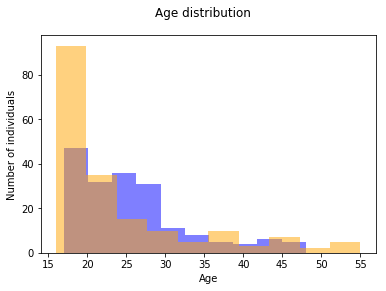

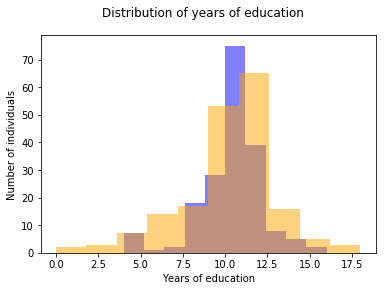

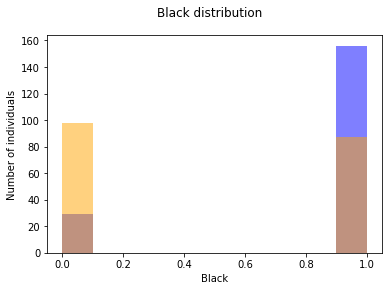

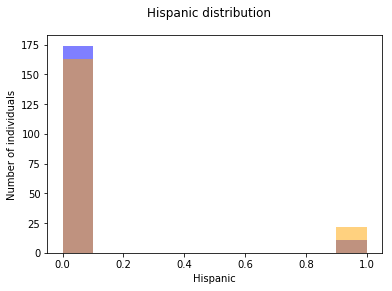

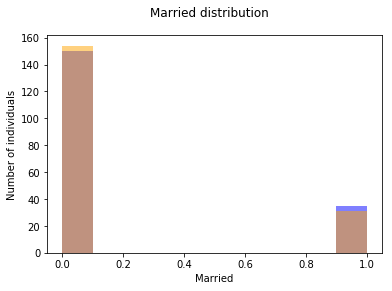

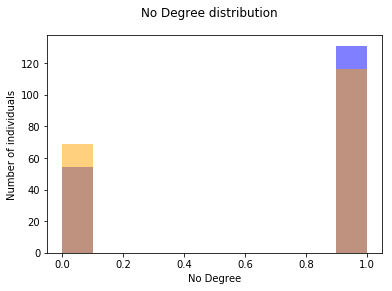

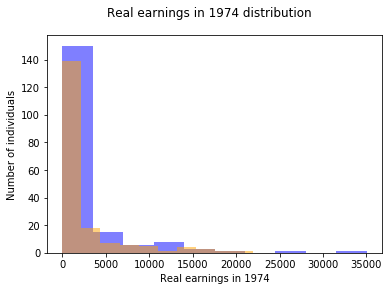

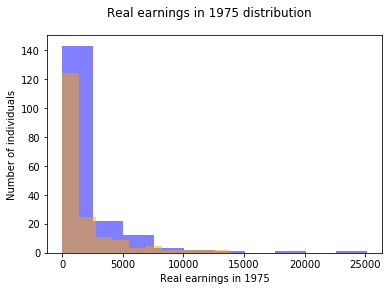

In [48]:
#Age distribution
plt.hist(df_treated_matched['age'],color="blue",alpha=0.5)
plt.hist(df_untreated_matched['age'],color="orange",alpha=0.5)
plt.ylabel("Number of individuals")
plt.xlabel("Age")
plt.suptitle("Age distribution")
plt.show()

#Educ distribution
plt.hist(df_treated_matched['educ'],color="blue",alpha=0.5)
plt.hist(df_untreated_matched['educ'],color="orange",alpha=0.5)
plt.ylabel("Number of individuals")
plt.xlabel("Years of education")
plt.suptitle("Distribution of years of education")
plt.show()


#Black distribution
plt.hist(df_treated_matched['black'],color="blue",alpha=0.5)
plt.hist(df_untreated_matched['black'],color="orange",alpha=0.5)
plt.ylabel("Number of individuals")
plt.xlabel("Black")
plt.suptitle("Black distribution")
plt.show()

#Hispanic distribution
plt.hist(df_treated_matched['hispan'],color="blue",alpha=0.5)
plt.hist(df_untreated_matched['hispan'],color="orange",alpha=0.5)
plt.ylabel("Number of individuals")
plt.xlabel("Hispanic")
plt.suptitle("Hispanic distribution")
plt.show()

#Married distribution
plt.hist(df_treated_matched['married'],color="blue",alpha=0.5)
plt.hist(df_untreated_matched['married'],color="orange",alpha=0.5)
plt.ylabel("Number of individuals")
plt.xlabel("Married")
plt.suptitle("Married distribution")
plt.show()

#No degree distribution
plt.hist(df_treated_matched['nodegree'],color="blue",alpha=0.5)
plt.hist(df_untreated_matched['nodegree'],color="orange",alpha=0.5)
plt.ylabel("Number of individuals")
plt.xlabel("No Degree")
plt.suptitle("No Degree distribution")
plt.show()

#re74 distribution
plt.hist(df_treated_matched['re74'],color="blue",alpha=0.5)
plt.hist(df_untreated_matched['re74'],color="orange",alpha=0.5)
plt.ylabel("Number of individuals")
plt.xlabel("Real earnings in 1974")
plt.suptitle("Real earnings in 1974 distribution")
plt.show()

#re75 distribution
plt.hist(df_treated_matched['re75'],color="blue",alpha=0.5)
plt.hist(df_untreated_matched['re75'],color="orange",alpha=0.5)
plt.ylabel("Number of individuals")
plt.xlabel("Real earnings in 1975")
plt.suptitle("Real earnings in 1975 distribution")
plt.show()

### Comments on features distribution: <br/>
After examining the distribution of the features of the two groups, we note that our model did in fact gather individuals that are very similar to each other. ***All the features except black have similar distributions (mean, standard deviation as well as median (percentiles))***. We have reached a good similarity except for the race feature and more specifically the number of black individuals in both groups.

### 5. Balancing the groups further

As mentioned before, the results we reached are not satisfying, the reason is that there is still a clear discrepancy regarding the feature black. <br/>
***Given the previous argument, we need to improve more our grouping***

In [50]:
#Get the number of black individuals from the original set
print (len(treated_df[treated_df['black']==1]) , " ", len(treated_df))
print (len(untreated_df[untreated_df['black']==1]), " ", len(untreated_df))

156   185
87   429


***A better way to do this is to repeat part 4 but this time only connect individuals from separate groups (treated and untreated/control) AND having the same race (black, white, hispanic)*** <br/>
Note that white is if the sample is not black or hispanic (from the given)

19277


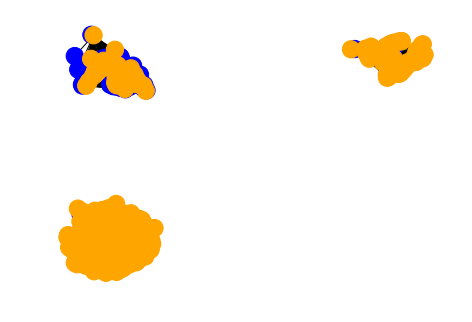

In [51]:
#Create an empty graph to fill
G_further = nx.empty_graph()

#Use a color map for visualization. 
#We follow the same schema as before but now we color based on the probability of belonging to treated or untreated group.
color_map = []
#Create the nodes without connecting them
for i in range(0,len(y_prob[:,1])):
    G_further.add_node(i)
    if(df_target[i] == 0):
        color_map.append('orange')
    else:
        color_map.append('blue')

#Connect the nodes with edges of values the inverse of the absolute difference between the probabilities
for i in range(0,len(y_prob[:,1])-1):
    for j in range(i+1,len(y_prob[:,1])):
        if(((df_target[i] == 0 and df_target[j] == 1) or (df_target[i] == 1 and df_target[j] == 0)) and (not G_further.has_edge(i,j)) and (df['black'][i] == df['black'][j]) and (df['hispan'][i] == df['hispan'][j])):
            if (abs(y_prob[i,1]-y_prob[j,1]) <= 0.000000000001): #To avoid overflow
                G.add_edge(i,j,weight=1000000000000) # Set it as an upper limit
            else:
                G_further.add_edge(i,j,weight=(1/abs(y_prob[i,1]-y_prob[j,1])))


#Print number of edges
print (G_further.number_of_edges())

#Visualize the graph
nx.draw(G_further,node_color = color_map)   

In [52]:
#Get the maximal matching based on the weights of the edges
#which will give us the indices of the pairs from the untreated to map 
#to the indices in the treated
matching = nx.max_weight_matching(G_further)

In [54]:
#Create treated and untreated df based on the matched pairs
index_treated_new = []
index_untreated_new = []

for index in matching:
    if(df_target[index] == 0):
        index_untreated_new.append(index)
    else:
        index_treated_new.append(index)
        
        
#Check that they are the same
#They contain the indices of the elements from the initial dataframe
print (len(index_untreated_new))
print (len(index_treated_new))

116
116


***Note here that the number of samples has droped from 185 to 116, the reason is that we are matching unique pairs and only the ones that have the same race.***

In [55]:
#Dataframe of treated and untreated based on the matched pairs
df_treated_matched_new = df.iloc[index_treated_new,:]
df_untreated_matched_new = df.iloc[index_untreated_new,:]

In [56]:
#Display both descriptions in one table -- for better visualization
#This one is for the matched groups after processing

index_array = df_treated_matched_new.describe().index
sum_df = pd.DataFrame(index = index_array)
attributes = ['age','age','educ','educ','black','black','hispan','hispan','married', 'married'
              ,'nodegree','nodegree','re74','re74','re75','re75']
columns = [('age','Treated Group'),('age','Untreated Group'),('educ','Treated Group'),('educ','Untreated Group')
           ,('black','Treated Group'),('black','Untreated Group'),('hispan','Treated Group'),('hispan','Untreated Group')
           ,('married','Treated Group'),('married','Untreated Group'),('nodegree','Treated Group'),('nodegree','Untreated Group')
          ,('re74','Treated Group'),('re74','Untreated Group'),('re75','Treated Group'),('re75','Untreated Group')]

combination_df  = pd.DataFrame(index = index_array, columns = columns)
combination_df.columns=pd.MultiIndex.from_tuples(columns)
i = 0
for col, att in zip(columns, attributes):
    if i%2==0:
        combination_df[col] = np.array(df_treated_matched_new[att].describe())
    else: 
        combination_df[col] = np.array(df_untreated_matched_new[att].describe())
    i+=1
        
combination_df

age                          educ                  \
      Treated Group Untreated Group Treated Group Untreated Group   
count    116.000000      116.000000    116.000000      116.000000   
mean      26.043103       25.250000     10.310345       10.224138   
std        7.442992       10.149213      2.144412        2.728549   
min       17.000000       16.000000      4.000000        1.000000   
25%       20.000000       18.000000      9.000000        9.000000   
50%       25.000000       20.500000     11.000000       11.000000   
75%       29.000000       30.000000     12.000000       12.000000   
max       48.000000       55.000000     16.000000       17.000000   

              black                        hispan                  \
      Treated Group Untreated Group Treated Group Untreated Group   
count    116.000000      116.000000    116.000000      116.000000   
mean       0.750000        0.750000      0.094828        0.094828   
std        0.434891        0.434891      0.294248        0.294248   
min        0.000000        0.000000      0.000000        0.000000   
25%        0.750000        0.750000      0.000000        0.000000   
50%        1.000000        1.000000      0.000000        0.000000   
75%        1.000000        1.000000      0.000000        0.000000   
max        1.000000        1.000000      1.000000        1.000000   

            married                      nodegree                  \
      Treated Group Untreated Group Treated Group Untreated Group   
count    116.000000      116.000000    116.000000      116.000000   
mean       0.241379        0.267241      0.689655        0.646552   
std        0.429776        0.444439      0.464642        0.480114   
min        0.000000        0.000000      0.000000        0.000000   
25%        0.000000        0.000000      0.000000        0.000000   
50%        0.000000        0.000000      1.000000        1.000000   
75%        0.000000        1.000000      1.000000        1.000000   
max        1.000000        1.000000      1.000000        1.000000   

               re74                          re75                  
      Treated Group Untreated Group Treated Group Untreated Group  
count    116.000000      116.000000    116.000000      116.000000  
mean    2351.177641     2846.645792   1587.197686     1882.169149  
std     5535.977124     4818.597225   3128.632029     2943.706810  
min        0.000000        0.000000      0.000000        0.000000  
25%        0.000000        0.000000      0.000000        0.000000  
50%        0.000000      515.287150      0.000000      555.000000  
75%     1171.078100     2760.117250   1677.872250     2302.802500  
max    35040.070000    21918.320000  17976.150000    13776.530000

***From the data description we find that we have a very close distribution for all the features and is an improvement from the grouping done in part 4. However, we would like to note that we lost some of our treated group as well since now we're studying 116 individuals instead of 185 (37% of our test individuals were not used)***

# 6. A less naive analysis

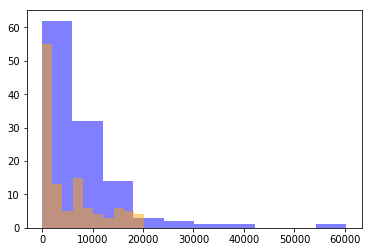

In [57]:
#Visualize the re78 after all processing
plt.hist(df_treated_matched_new['re78'],color="blue",alpha=0.5)
plt.hist(df_untreated_matched_new['re78'],color="orange",alpha=0.5)
plt.show()

In [58]:
df_treated_matched_new.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,116.0,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,1.0,26.043103,10.310345,0.750000,0.094828,0.241379,0.689655,2351.177641,1587.197686,7045.667114
std,0.0,7.442992,2.144412,0.434891,0.294248,0.429776,0.464642,5535.977124,3128.632029,8621.012734
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,672.490925
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,5130.757500
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1171.078100,1677.872250,10011.045500
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,17976.150000,60307.930000


In [59]:
df_untreated_matched_new.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,116.0,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,0.0,25.250000,10.224138,0.750000,0.094828,0.267241,0.646552,2846.645792,1882.169149,4968.638912
std,0.0,10.149213,2.728549,0.434891,0.294248,0.444439,0.480114,4818.597225,2943.706810,5855.641206
min,0.0,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,18.000000,9.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,20.500000,11.000000,1.000000,0.000000,0.000000,1.000000,515.287150,555.000000,2283.087500
75%,0.0,30.000000,12.000000,1.000000,0.000000,1.000000,1.000000,2760.117250,2302.802500,7866.308250
max,0.0,55.000000,17.000000,1.000000,1.000000,1.000000,1.000000,21918.320000,13776.530000,20243.380000


# Conclusion to first part of the homework

***In the first part, we had individuals that are not similar to each other in many ways one of which was that the control group had an initial high salary compared to the test group, which led a naive scientist to think that the training program doesn't improve the income. However, after matching them based on their propensity score, we were able to see that the program might improve but we had a problem with the distribution of the features as theirs was a disrepancy in the distribution of the feature black. After inforcing that the match take into account the race feature, we were able to have a very close distribution for all the features between the control and test group.***
### Now we can clearly say that the program did in fact increase the earning of the individuals who took it.


# Part 2

In [60]:
#When loading the data remove headers, footers, quotes to make sure classification won't overfit (from documentation)
newsgroups_train = fetch_20newsgroups(subset='train',remove=('headers', 'footers', 'quotes'))

#Load it into pandas DF
news_df = pd.DataFrame(data= np.c_[newsgroups_train.data, newsgroups_train.target],
                     columns= ['article_text','article_category'])
news_df.head()

,article_text,article_category
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,\nDo you have Weitek's address/phone number? ...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14


## Subpart 1

Create all the functions needed for the text preprocessing

In [62]:
def remove_link(sentence):
    """
    Remove links
    :param sentence: where we want to remove the link
    :return: the sentence without a link
    """
    result = ""
    for word in sentence.split():
        if(not(word[:4] == "http") and not(word[0] == '&') and not(word[len(word)-1] == ';')):
            result += " " + word

    #Trim result from left and right
    return result.lstrip().rstrip()

def remove_special_characters(sentence):
    """
    Remove special characters
    :param sentence: the sentence from where we remove the characters
    :return: the sentences without the special characters
    """
    sentence_no_specials = []
    for item in sentence:
        try:
            sentence_no_specials.append(
                item.replace('\r', ' ').replace('\n', ' ').replace('\'','')\
                    .replace('.', ' ').replace(',', ' ').replace('(', ' ') \
                    .replace(')', ' ').replace('"', ' ').replace('*', ' ') \
                    .replace('!', ' ').replace('?', ' ') \
                    .replace('>', ' ').replace('$', ' ') \
                    .replace('-', '').replace(';', ' ') \
                    .replace(':', ' ').replace('/', ' ').replace('#', ' ').replace('@',' '))
        except:
            sentence_no_specials.append("")
    
    result = ""
    for ch in sentence_no_specials:
            result = result + ch
    return result

def remove_numerical(sentence):
    """
    remove the words containing numbers
    :param sentence: 
    :return: 
    """
    result = ""
    for word in sentence.split():
        new_word = ''.join([i for i in word if not i.isdigit()])
        result = result + " " + new_word
    return result
        
def clean_text(sentence):
    """
    remove special characters, stop words and numbers, lemmatize and remove non-english words 
    :param sentence: sentence to clean
    :param tester: which element you would like to display as an example
    :return: the cleaned sentence
    """
    lemmatizer = WordNetLemmatizer()

    # Remove link
    sentence_no_link = remove_link(sentence)
    
    # Remove numbers
    sentence_no_link_no_numeric = remove_numerical(sentence_no_link)
    
    #Everything to lower case
    sentence_lower_no_link_no_numeric = sentence_no_link_no_numeric.lower()
    
    # Remove special characters
    sentence_no_specials = remove_special_characters(sentence_lower_no_link_no_numeric)
    
    # Keep only characters (if there's chinese characters for example)
    sentence_characters_only = re.sub('[^a-z]+', ' ',sentence_no_specials)
    
    # Lemmatize words
    sentence_lemmatized = " ".join([lemmatizer.lemmatize(token) for token in sentence_characters_only.split() ])
    
    # Remove stop words
    sentence_almost_finished = " ".join([token for token in sentence_lemmatized.split() if (token not in STOPWORDS)])
    
    # remove words with length equal to 1
    sentence_finished = " ".join([token for token in sentence_almost_finished.split() 
                                                       if (len(token)>1)])
    
    #Trim from both ends and return sentence
    return sentence_finished.lstrip().rstrip()


In this part, we will do the preprocessing on all the dataframe (train, tune and test) because it's gonna be the same.

In [63]:
# Apply preprocessing for all the dataset
news_df['article_text'] = news_df['article_text'].apply(clean_text)

We will be following here the instructions specified in the homework. The instructions state that we should fit a tf-idf vectorizer to our data then to split it into training, tuning and testing sets. ***However, in this case there will be a leakage from the training to the tuning and testing since the tf-idf score of a word will change if it is present in both the training and testing (if we were fitting the tf-idf on training alone, we may see different scores)***

In [64]:
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(news_df['article_text'])
X_vectorized.shape

(11314, 79545)

Note that we do not need to standardize/normalize our data since it's been already taken care of by the fit_transform

In [65]:
# Assign random state to make results reproducible
random_state = 1

# Separate training and the rest (tuning and testing) (80%, 20%)
y = news_df['article_category'].as_matrix()
X_train, X_temp, y_train, y_temp = train_test_split(X_vectorized, y, test_size=0.2, random_state=random_state)

# Now we will separate tuning and testing to get 10% and 10% of the initial dataframe
X_tune, X_test, y_tune, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)


## Subpart 2

***Prunning is usually used to avoid overfitting of a decision tree. However, Scikit Learn's built library for Random Forest doesn't support pruning. Since it wasn't specified on how the training was supposed to be done, we will do a 5 fold cross validation on our training set and then plot the confusion matrix for the testing set.***

In [80]:
# tuning requested parameter
tuned_parameters = [{'n_estimators': range(21,27,1),'max_depth':range(270,300,5)}]
# Used 5 folds cross validation because it's better to do it this way
# Used accuracy for scoring since we want to pick a model based on how many it classifies correctly
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf.fit(X_train,y_train)
clf.best_params_

{'max_depth': 295, 'n_estimators': 26}

In [81]:
# best n_estimators and max_depth obtained using GridSearchCV
best_n_estimator = clf.best_params_['n_estimators']
best_max_depth = clf.best_params_['max_depth']

In [82]:
# assessing best performing regression tree on test set
rfc = RandomForestClassifier(n_estimators=best_n_estimator, max_depth=best_max_depth)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
accuracy_score(y_test, y_pred)

0.607773851590106

***Given that we have 20 categories to classify the text, a random classifier would reach an accuracy of around 5%. This is a good way to prove that our model is actually a good model***

In [83]:
# define a function to draw the confusion matrix 
# apply normalization by setting `normalize=True`.
# Dataset is already normalized from the tf-idf vectorizer
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds):
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round (cm[i, j],2), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization
[[23  0  1  0  0  4  1 10  6  2  1  2  0  0  1  0  0  0  3  0]
 [ 1 41  0  0  1  0  2  0  0  0  0  0  3  1  1  2  1  0  0  1]
 [ 0  1 41  0  0  1  2  1  0  1  1  1  0  0  0  0  2  1  4  4]
 [ 0  0  2 47  3  1  1  0  1  0  0  0  1  0  0  0  0  1  3  0]
 [ 0  4  1  0 29  0  4  0  0  0  0  0  1  3  2  2  2  7  2  2]
 [ 0  3  1  0  0 36  3  2  1  0  0  0  0  0  0  1  2  4  1  1]
 [ 2  4  0  0  1  1 33  0  1  0  1  1  3  1  1  1  0  1  4  1]
 [ 5  0  1  0  0  2  0 44  0  3  0  3  0  1  0  0  0  2  3  3]
 [ 0  0  0  3  1  1  0  1 39  0  1  1  1  0  1  0  0  1  3  3]
 [ 2  0  0  0  0  1  1  2  1 42  2  1  0  0  2  0  0  2  6  4]
 [ 3  1  3  1  2  2  1  2  5  1 17  0  1  0  1  0  1  1  6  4]
 [ 8  0  0  2  0  3  2  8  6  1  0  4  1  0  0  1  0  2  5  1]
 [ 0  2  0  1  1  0  0  0  0  0  0  0 33  3  3 10  2  0  2  0]
 [ 0  5  0  1  4  0  0  0  0  0  0  0  2 35  5  1  6  1  1  0]
 [ 0  1  1  1  2  0  0  0  0  0  0  0  1  0 29  2  2  1  4  1]
 [ 0  5  0  1  

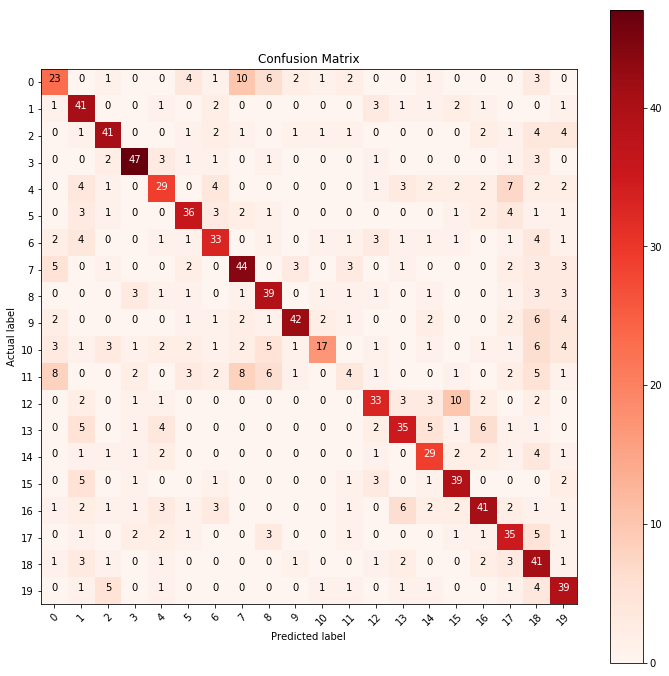

In [84]:
# confusion matrix for unseen data
classes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
cm = confusion_matrix(y_test, y_pred)

#For better visualization
plot_confusion_matrix(cm, classes, normalize=False)

In [85]:
# Plot histogram of most N important features
def print_most_important_features(feature_importances,N):
    most_important_features_by_indices = np.argsort(feature_importances)[::-1][:N]
    x = np.arange(1, N+1)
    y = []
    my_xticks = []
    for index in most_important_features_by_indices:
        my_xticks.append(vectorizer.get_feature_names()[index])
        y.append(feature_importances[index])
    plt.figure(figsize=(N,6))
    plt.xticks(x, my_xticks)
    plt.bar(x, y, color="blue")
    plt.suptitle("Importance of words")
    plt.xlabel("Words")
    plt.ylabel("TF-IDF score")

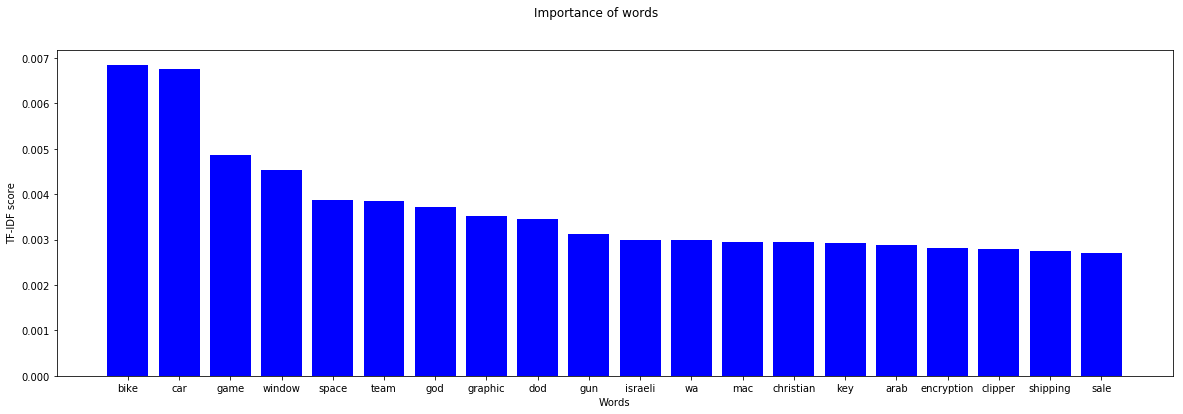

In [86]:
#Specify how many of the most important terms to display
most_important_n = 20
print_most_important_features(rfc.feature_importances_,most_important_n)

In [87]:
# Matching our results with the different categories
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

## Conclusion
We note that the results we found for the most important words are accurate with respect to the 20 categories we have. For example, "god" would go with the religion category, gun would go into the guns category etc. <br/>
Random Forest creates multiple decision trees by sampling either features/samples and each tree would use the entropy score to rank the feature with the most information gain to be at the first level. We clearly see that these cuts use words that are very specific to a category (such as "gun") which is mostly specific to religion and should not be present for example in "hardware" category.